**Importing the libraries which will be needed and preparing the data set**

In [ ]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

**Loading the Animal Dataset**

In [ ]:
import os
data_path = fr'I:/gift/AnimalFace/Image'
os.listdir(data_path)

['BearHead',
 'CatHead',
 'ChickenHead',
 'CowHead',
 'DeerHead',
 'DogHead',
 'DuckHead',
 'EagleHead',
 'ElephantHead',
 'HumanHead',
 'LionHead',
 'MonkeyHead',
 'MouseHead',
 'Natural',
 'PandaHead',
 'PigeonHead',
 'PigHead',
 'RabbitHead',
 'SheepHead',
 'TigerHead',
 'WolfHead']

Now creating the dataset. Note this step is not required every time running the notebook as the data is stored as a pkl, which can be loaded directly next time.

**There are quite some animals included in the dataset. Also set the width (and height) to 80 pixels.**

In [ ]:
base_name = 'animal_faces'
width = 80
 
include = {'ChickenHead', 'BearHead', 'ElephantHead', 
           'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

BearHead
ChickenHead
DeerHead
EagleHead
ElephantHead
MonkeyHead
PandaHead


**Let’s load the data from disk and print a summary.**

In [ ]:
from collections import Counter
import numpy as np
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  716
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)animal images in rgb
image shape:  (80, 80, 3)
labels: ['Bear' 'Chicken' 'Deer' 'Eagle' 'Elephant' 'Monkey' 'Panda']


Counter({'Bear': 101,
         'Chicken': 100,
         'Deer': 101,
         'Eagle': 97,
         'Elephant': 100,
         'Monkey': 100,
         'Panda': 117})

**The images below show an example of each animal included.**

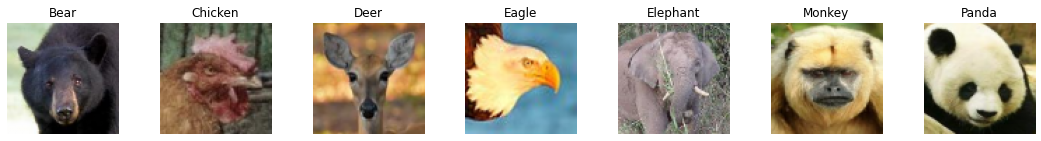

In [ ]:
import matplotlib.pyplot as plt
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

**By convention, we name the input data X and result (labels) y**

In [ ]:
X = np.array(data['data'])
y = np.array(data['label'])

**The train_test_split function in sklearn provides a shuffle parameter to take care of this while doing the split. The random_state seeds the shuffling so that it is random, but in a reproducible way.**

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

**To verify that the distribution of photos in the training and test set is similar, let’s look at the relative number of photos per category.**

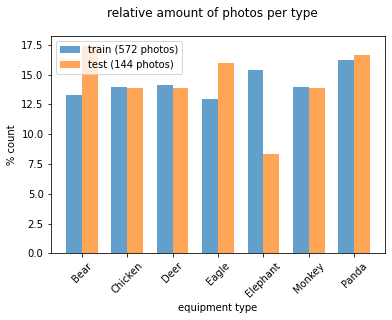

In [ ]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

To calculate a HOG, an image is divided into blocks, for example 8 by 8 pixels. For each of these blocks, the magnitude of the gradient in a given number of directions is calculated.

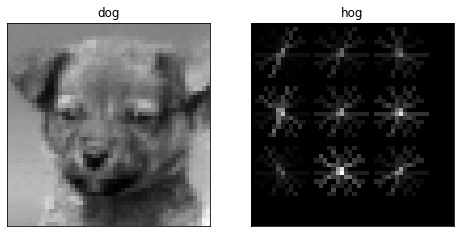

In [ ]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
dog = imread('I:/gift/AnimalFace/Image/DogHead/dog000006a.jpg', as_gray=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
dog = rescale(dog, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [ ]:
print('number of pixels: ', dog.shape[0] * dog.shape[1])
print('number of hog features: ', dog_hog.shape[0])

number of pixels:  2304
number of hog features:  144


A custom transformer can be made by inheriting from these two classes and implementing an __init__, fit and transform method. The TransformerMixin class provides the fit_transform method, which combines the fit and transform that implemented.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Note that for compatibility with scikit-learn, the fit and transform methods take both X and y as parameters, even though y is not used here.

With this, all set to preprocess our RGB images to scaled HOG features.

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(572, 576)


The next step is to train a classifier and start with Stochastic Gradient Descent (SGD), because it is fast and works reasonably well.

First create an instance and then we call the fit method passing training data and labels.

In [ ]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

To test the trained SGD classifier, we will use our test set. First, we transform it using the same transformers as before. However, we must take care that our test data will not influence the transformers.  To prevent this, we call transform and not fit_transform on the test data.

In [ ]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

**Next, to make a prediction for the test set and look at the results.** 

In [ ]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True False  True  True  True  True False  True False  True  True  True
  True  True False  True  True  True False  True  True  True  True False
  True]

Percentage correct:  80.55555555555556


To get more insight in the results, we can use a correlation matrix. This is a table where each row corresponds to a label, and each column to a predictions using a pandas dataframe with some yes/no data.

In [ ]:
import pandas as pd
labels = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',  'no', 'no', 'no']
predictions = ['yes', 'yes', 'yes', 'yes', 'no',  'no',  'yes', 'no', 'no', 'no']
 
# put the data in a dataframe for pretty printing
df = pd.DataFrame(
    np.c_[labels, predictions], 
    columns=['true_label', 'prediction']
)
df

,true_label,prediction
0,yes,yes
1,yes,yes
2,yes,yes
3,yes,yes
4,yes,no
5,yes,no
6,no,yes
7,no,no
8,no,no
9,no,no


The confusion matrix for the SGD test is a 8×8 matrix. As above, correct predictions appear on the main diagonal, whereas all off-diagonal values correspond to incorrect classifications.

In [ ]:
from sklearn.metrics import confusion_matrix
 
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,yes,no
label,,
yes,4,2
no,1,3


Another way to represent this is in the form of a colormap image.

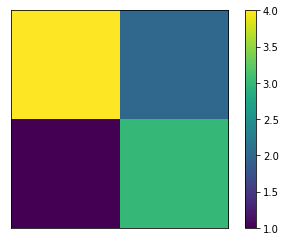

In [ ]:
plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar();

The confusion matrix for the SGD test is a 8×8 matrix. As above, correct predictions appear on the main diagonal, whereas all off-diagonal values correspond to incorrect classifications.

In [ ]:
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[20,  0,  0,  1,  2,  1,  1],
       [ 0, 18,  0,  2,  0,  0,  0],
       [ 1,  0, 17,  0,  2,  0,  0],
       [ 1,  3,  0, 16,  1,  1,  1],
       [ 1,  0,  1,  0,  9,  1,  0],
       [ 2,  0,  0,  0,  0, 15,  3],
       [ 3,  0,  0,  0,  0,  0, 21]], dtype=int64)

The largest values are on the diagonal, hence most predictions are correct, but there are mistakes (~15%). To visualise this more clearly as an image, we do two things.


 ['Bear', 'Chicken', 'Deer', 'Eagle', 'Elephant', 'Monkey', 'Panda']


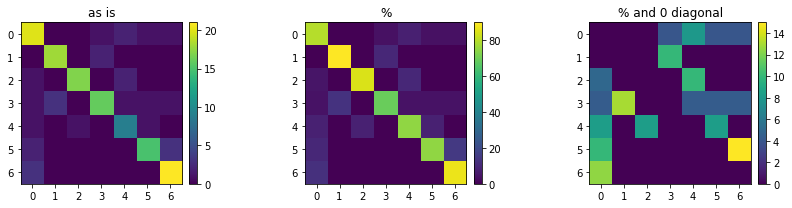

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))


The pipeline fit method takes input data and transforms it in steps by sequentially calling the fit_transform method of each transformer. The data is passed from output to input until it reaches the end or the estimator if there is one. When the last item in the pipeline is an estimator, its fit method is called to train the model using the transformed data.

The resulting object can be used directly to make predictions. Test data is passed into the predict method, which calls the transform methods, followed by predict in the final step.

In [ ]:
	
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  80.55555555555556


A huge advantage here is that, by using our pipeline, we can optimise both the transformations and the classifier in a single procedure. Additionally, instead of manually modifying parameters, we will use GridSearchCV. First define a parameter grid, as shown in the cell below

In [ ]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

Next,creating a GridSearchCV object, passing the pipeline, and parameter grid. In addition we use cv=3. This parameter sets up cross validation.  For the final parameter, the score, we use ‘accuracy’, the percentage of true positive predictions. In other cases it might be more useful to use check false positives or another statistic.

The n_jobs parameter specifies the number of jobs we wish to run in parallel. We set its value to -1 to use all available cores. 

To parallelise under Windows, it is necessary to run this code from a script, inside an if __name__ == ‘__main__’ clause.

In [ ]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [ ]:
from sklearn.svm import SVC
Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear'))])


Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear'))])

In [ ]:
grid_res.best_score_

0.9143106457242584

Going back to GridSearchCV results, the best results were obtained with a linear SVM. As a final test I use the model to make predictions for testing set.

In [ ]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  90.97222222222223


The accuracy went up from 85% to 92%. To get some more insight, we can compare the confusion matrices before and after optimisation. Note that the colour ranges are set to the larger of either two, for sake of comparison.

In [ ]:
cmx_svm = confusion_matrix(y_test, best_pred)

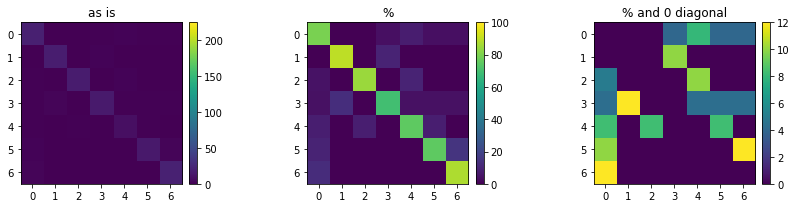

In [ ]:
plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)